In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('./drive/MyDrive/266_project/project/')
!ls

 01_pre_processing.py		  06_embeddings_analysis.ipynb	   project_utils.py
 02_model_hpo.py		 '266 Final Project.gslides'	  'Project Write Up.gdoc'
 03_hpo_analysis.ipynb		 '266 Project Proposal.gdoc'	   __pycache__
 04_train.py			 'Copy of Project Write Up.gdoc'   requirements.txt
 05_prediction.ipynb		  global_vars.py		   support
 05_predict.py			  graveyard
 06_embedding_analysis_mk.ipynb   graveyard.py


In [ ]:
import pandas as pd
CNNForWord2VecBERTweet_test_df = pd.read_pickle('./support/CNNForWord2VecBERTweet_test_df.pkl')
CNNForWord2VecBERTweet_test_df.to_csv(r'./support/CNNForWord2VecBERTweet_test_df.csv')

In [ ]:
"""
Embedding analysis
Review of the embedding space to determine opportunities for improvement on fine-tuning set
"""

# Import packages
# Admin
import os
import time
import re
import optuna

# Data
import pandas as pd
import numpy as np
import random

# Gradients
import csv
import pickle

# Custom modules
from global_vars import GVD, FPATH
from project_utils import calculate_metrics, determine_category

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

#pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

#plotting for embedding analysis
import plotly.graph_objs as go

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# Perform and Visualize LDA
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# Instantiate dataframe for each model performance result
project_dict = {'NAME':'CNNForWord2VecBERTweet', 'W2V': True, 'FINETUNING':False, 'BASELINE': False, 'CONFIG':'vinai/bertweet-base'}
df = pd.read_pickle(FPATH + project_dict['NAME']+'_test_df.pkl')
train_df = pd.read_pickle(FPATH + 'CNNForWord2VecBERTweet_train_df.pkl')


# Get embeddings

In [ ]:
# Assign TP and TN status to train set
train_df['category'] = train_df['label'].apply(lambda x: 'TP' if x==1 else 'TN')

# Filter for True Positives and True Negatives
df_TP = train_df[train_df['category'] == 'TP']
df_TN = train_df[train_df['category'] == 'TN']

In [ ]:
# Compute centroids
centroid_TP = np.mean(np.stack(df_TP['embeddings']), axis=0)
centroid_TN = np.mean(np.stack(df_TN['embeddings']), axis=0)

# Compute the cosine similarity between the two centroids
cos_sim_between_centroids = cosine_similarity([centroid_TP], [centroid_TN])[0][0]

# Function to calculate similarity to opposite and same class
def calc_opposite_and_same_class_similarities(row, centroid_TP, centroid_TN):
    if row['label'] == 1:
        sim_to_same_class = cosine_similarity([row['embeddings']], [centroid_TP])[0][0]
        sim_to_opp_class = cosine_similarity([row['embeddings']], [centroid_TN])[0][0]
    else:
        sim_to_same_class = cosine_similarity([row['embeddings']], [centroid_TN])[0][0]
        sim_to_opp_class = cosine_similarity([row['embeddings']], [centroid_TP])[0][0]
    return pd.Series([sim_to_opp_class, sim_to_same_class], index=['sim_to_opp_class', 'sim_to_same_class'])

# Apply the function to each row in the DataFrame to create new columns
df[['sim_to_opp_class', 'sim_to_same_class']] = df.apply(
    calc_opposite_and_same_class_similarities,
    centroid_TP=centroid_TP,
    centroid_TN=centroid_TN,
    axis=1
)

# Apply the function to each row in the DataFrame and create new columns
df.sort_values(by=['category','sim_to_opp_class'], ascending=[True,False], inplace=True)

In [ ]:
df = df[['text', 'label', 'pred', 'probs','category', 'sim_to_opp_class', 'sim_to_same_class','embeddings']]

In [ ]:
df_adjusted = df.copy()

def adjust_pred(row):
    if row['sim_to_opp_class'] >= 0.65 and row['sim_to_same_class'] < 0.25 and row['pred'] == 1:
        return 0
    elif row['sim_to_opp_class'] >= 0.65 and row['sim_to_same_class'] < 0.25 and row['pred'] == 0:
        return 1
    else:
        return row['pred']

# Function to determine category
def determine_category_adj(row):
    if row['label'] == 1 and row['pred_adj'] == 1:
        return 'TP'  # True Positive
    elif row['label'] == 0 and row['pred_adj'] == 0:
        return 'TN'  # True Negative
    elif row['label'] == 0 and row['pred_adj'] == 1:
        return 'FP'  # False Positive
    elif row['label'] == 1 and row['pred_adj'] == 0:
        return 'FN'  # False Negative

df_adjusted['pred_adj'] = df_adjusted.apply(adjust_pred, axis=1)
df_adjusted['category_adj'] = df_adjusted.apply(determine_category_adj, axis=1)

In [ ]:
print(df.category.value_counts())
print(df_adjusted.category_adj.value_counts())

category
TN    1436
TP    1235
FN     265
FP      64
Name: count, dtype: int64
category_adj
TN    1499
TP    1355
FN     145
FP       1
Name: count, dtype: int64


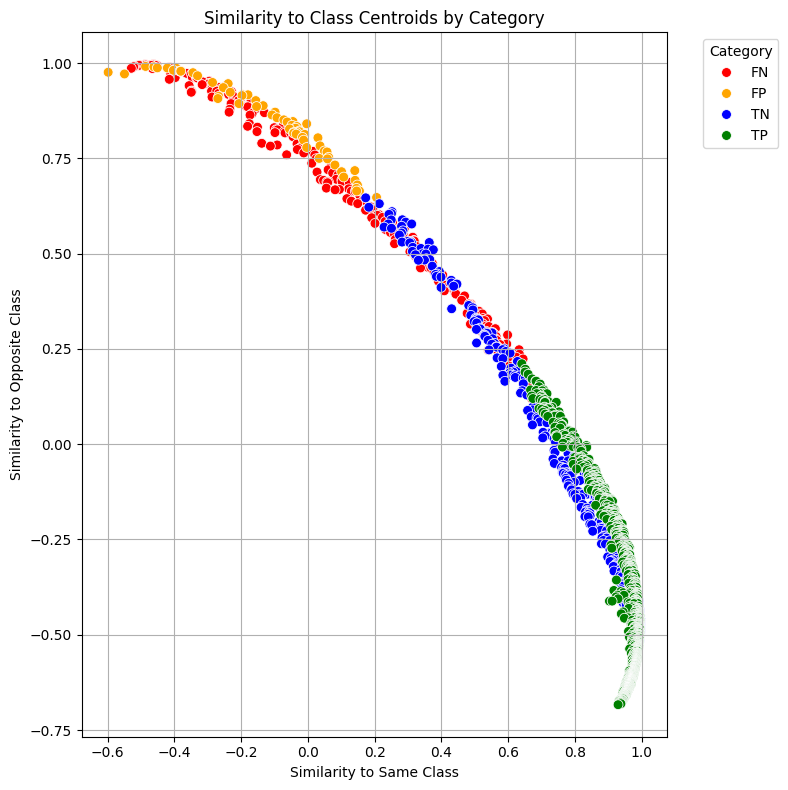

In [ ]:
# Custom palette for categories
category_palette = {'FN': 'red', 'TN': 'blue', 'FP': 'orange', 'TP': 'green'}

# Plotting
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df,
    x='sim_to_same_class',
    y='sim_to_opp_class',
    hue='category',
    palette=category_palette,
    s=50
)
plt.title('Similarity to Class Centroids by Category')
plt.xlabel('Similarity to Same Class')
plt.ylabel('Similarity to Opposite Class')
plt.grid(True)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


In [ ]:
# True labels
y_true = df['label']

# Adjusted predictions
y_pred = df['pred']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate and display a classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate a confusion matrix and convert it to a DataFrame for better readability
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

conf_matrix_df

Accuracy: 0.89
Recall: 0.82
Precision: 0.95
F1 Score: 0.88
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90      1500
         1.0       0.95      0.82      0.88      1500

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



,Predicted Negative,Predicted Positive
Actual Negative,1436,64
Actual Positive,265,1235


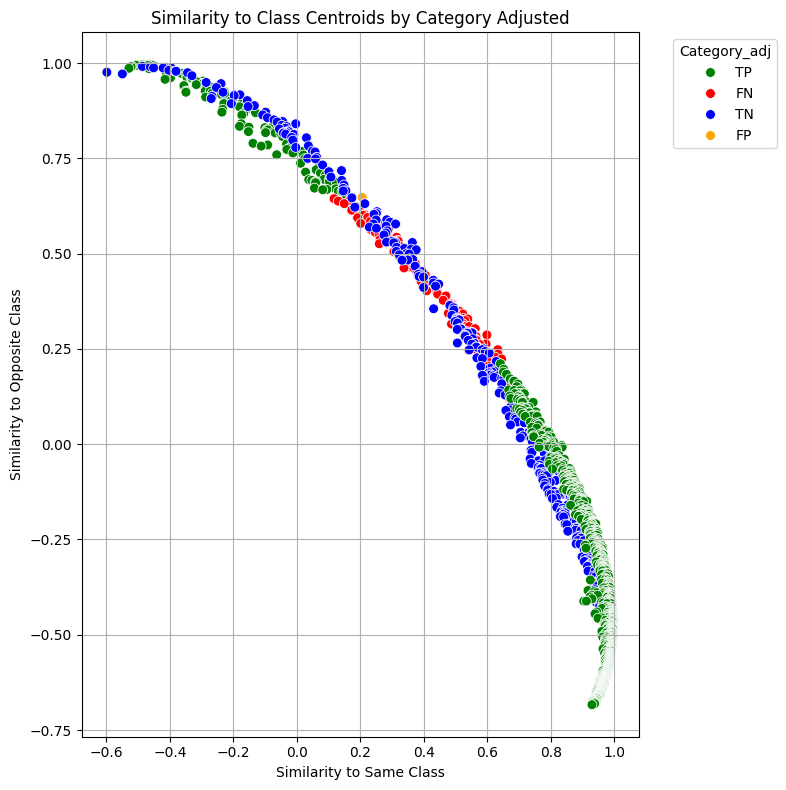

In [ ]:
# Plotting
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=df_adjusted,
    x='sim_to_same_class',
    y='sim_to_opp_class',
    hue='category_adj',
    palette=category_palette,
    s=50
)
plt.title('Similarity to Class Centroids by Category Adjusted')
plt.xlabel('Similarity to Same Class')
plt.ylabel('Similarity to Opposite Class')
plt.grid(True)
plt.legend(title='Category_adj', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
# True labels
y_true = df_adjusted['label']

# Adjusted predictions
y_pred = df_adjusted['pred_adj']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate and display a classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Generate a confusion matrix and convert it to a DataFrame for better readability
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

conf_matrix_df


Accuracy: 0.95
Recall: 0.90
Precision: 1.00
F1 Score: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      1500
         1.0       1.00      0.90      0.95      1500

    accuracy                           0.95      3000
   macro avg       0.96      0.95      0.95      3000
weighted avg       0.96      0.95      0.95      3000



,Predicted Negative,Predicted Positive
Actual Negative,1499,1
Actual Positive,145,1355


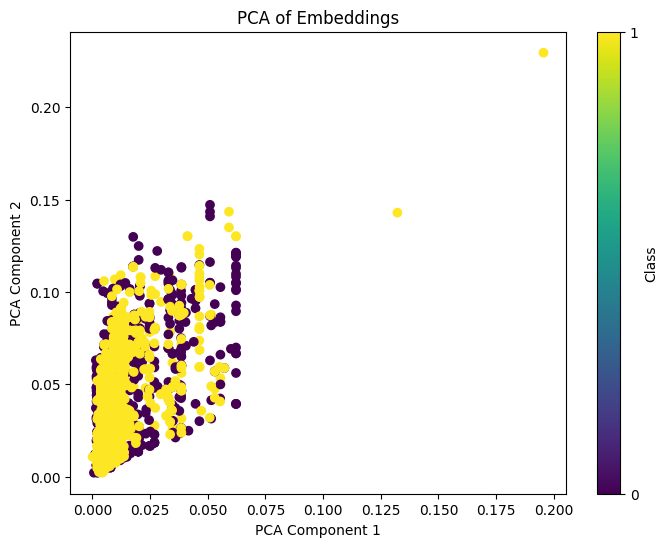

In [ ]:
embeddings = np.stack(df['embeddings'].values)
labels = df['label'].values

# Plotting the PCA-reduced embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels)
plt.title('PCA of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(ticks=[0, 1], label='Class')
plt.show()


# Topic modeling

In [ ]:
def preprocess_text(text):
    # Tokenize text
    tokens = nltk.word_tokenize(text.lower())
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    return lemmatized_output

# Preprocess text
train_df['processed_text'] = train_df['text'].apply(lambda x: preprocess_string(x))

# Split dataframes
fp = train_df[train_df['category']=='FP'].copy().reset_index()[['processed_text']]
fn = train_df[train_df['category']=='FN'].copy().reset_index()[['processed_text']]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def run_lda(df, num_topics=3):

  # Create a dictionary and corpus for LDA
  dictionary = corpora.Dictionary(df['processed_text'])
  corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

  # Set training parameters.
  num_topics = num_topics
  chunksize = 2000
  passes = 20
  iterations = 400
  eval_every = None

  # Make a index to word dictionary.
  temp = dictionary[0]
  id2word = dictionary.id2token

  # Compute coherence for different numbers of topics
  model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['processed_text'], limit=20)

  # Plotting
  x = range(2, 20, 3)
  plt.figure(figsize=(10, 5))
  plt.plot(x, coherence_values)
  plt.xlabel("Number of Topics")
  plt.ylabel("Coherence score")
  plt.title("Coherence Scores for Different Numbers of Topics")
  plt.grid(True)
  plt.show()

  # Instantiate model
  model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes,
      eval_every=eval_every
  )

  # Prepare visualization with pyLDAvis
  pyLDAvis.enable_notebook()
  vis = gensimvis.prepare(model, corpus, dictionary)
  pyLDAvis.display(vis)

  return vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


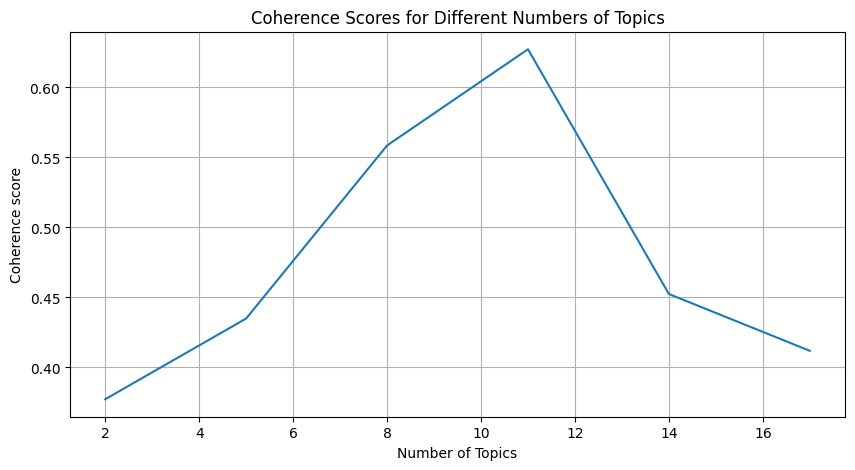

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.080563 -0.047875       1        1  47.200478
1      0.099527 -0.024888       2        1  36.396385
0     -0.018964  0.072764       3        1  16.403137, topic_info=        Term      Freq     Total Category  logprob  loglift
44    believ  4.000000  4.000000  Default   30.000  30.0000
82   countri  1.000000  1.000000  Default   29.000  29.0000
17    answer  1.000000  1.000000  Default   28.000  28.0000
3        god  3.000000  3.000000  Default   27.000  27.0000
21   problem  0.000000  0.000000  Default   26.000  26.0000
..       ...       ...       ...      ...      ...      ...
22     think  0.501738  1.476480   Topic3   -4.155   0.7284
0      admit  0.501739  1.538881   Topic3   -4.155   0.6870
88     world  0.501738  1.538881   Topic3   -4.155   0.6870
104     sure  0.501733  1.538884   Topic3   -4.155   0.6870
10     peopl  0.501732  3.953154   Topic3   -4.155  -0.2565

[132 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
111       1  0.860159    absolut
16        3  1.106045      accus
112       1  0.556375     actual
36        3  1.106043  administr
0         1  0.649823      admit
...     ...       ...        ...
59        2  0.908948       wall
158       1  0.860159       warp
88        1  0.649823      world
88        3  0.649823      world
60        2  0.597893       year

[105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
fp_vis = run_lda(fp, num_topics=3)
fp_vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


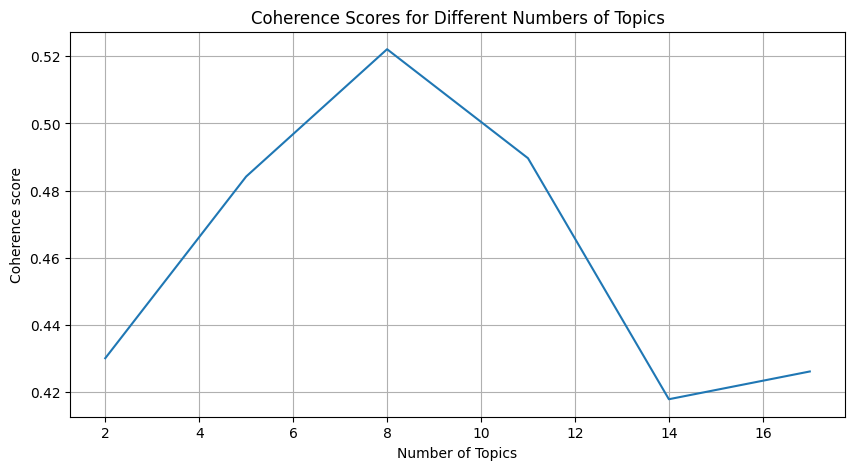

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.076191  0.069004       1        1  38.151115
1     -0.106460  0.023176       2        1  34.998077
0      0.030269 -0.092179       3        1  26.850809, topic_info=       Term      Freq     Total Category  logprob  loglift
17     love  7.000000  7.000000  Default  30.0000  30.0000
924  theori  6.000000  6.000000  Default  29.0000  29.0000
163  nation  4.000000  4.000000  Default  28.0000  28.0000
506    post  5.000000  5.000000  Default  27.0000  27.0000
575   forum  5.000000  5.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
108    life  1.337489  6.361101   Topic3  -6.0671  -0.2445
15      law  1.337480  4.989992   Topic3  -6.0671  -0.0018
168   obama  1.337478  3.060790   Topic3  -6.0671   0.4870
157   sorri  1.337477  3.080496   Topic3  -6.0671   0.4806
892  welcom  1.337476  2.404787   Topic3  -6.0671   0.7282

[180 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
495       3  0.860073       abort
585       1  0.768750       amend
86        1  0.877466    american
935       2  0.527726  antarctica
42        1  0.526343        anti
...     ...       ...         ...
582       2  0.884841         www
582       3  0.176968         www
229       1  0.660435        year
229       2  0.132087        year
229       3  0.264174        year

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
fn_vis = run_lda(fn, num_topics=3)
fn_vis